<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [16]</a>'.</span>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import gc

from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn import impute
from sklearn import pipeline
from scipy.spatial import distance

import optuna
from optuna.visualization import (
    plot_contour
    , plot_edf
    , plot_intermediate_values
    , plot_optimization_history
    , plot_parallel_coordinate
    , plot_param_importances
    , plot_slice
)

pd.set_option('display.max_columns', None)


import plotly.express as px
import plotly.io as pio
pio.renderers.default = "png"

/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


***
## loading data

In [2]:
input_path = "../data/raw"

train = pd.read_csv(f"{input_path}/train.csv")
test  = pd.read_csv(f"{input_path}/test.csv")
greeks = pd.read_csv(f"{input_path}/greeks.csv")

train.columns = [col.strip() for col in train.columns]
test.columns = [col.strip() for col in test.columns]

# available features
input_cols = train.columns[1:-1]
categ_cols = ["EJ"]

# we extend train with dummies from greeks
dummies = pd.get_dummies(greeks[["Alpha","Beta","Gamma","Delta"]])
train[dummies.columns] = dummies

# encode of categorical features
encoder = preprocessing.LabelEncoder().fit(train["EJ"])
train["EJ"] = encoder.transform(train["EJ"]).astype(int)
test["EJ"] = encoder.transform(test["EJ"]).astype(int)

display(train)

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EJ,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class,Alpha_A,Alpha_B,Alpha_D,Alpha_G,Beta_A,Beta_B,Beta_C,Gamma_A,Gamma_B,Gamma_E,Gamma_F,Gamma_G,Gamma_H,Gamma_M,Gamma_N,Delta_A,Delta_B,Delta_C,Delta_D
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,22.5984,175.638726,152.707705,823.928241,257.432377,47.223358,0.563481,23.387600,4.851915,0.023482,1.050225,0.069225,13.784111,1.302012,36.205956,69.08340,295.570575,0.238680,0.284232,89.245560,84.31664,29.657104,5.310690,1.74307,23.187704,7.294176,1.987283,1433.166750,0.949104,1,30.879420,78.526968,3.828384,13.394640,10.265073,9028.291921,3.583450,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,19.4205,155.868030,14.754720,51.216883,257.432377,30.284345,0.484710,50.628208,6.085041,0.031442,1.113875,1.117800,28.310953,1.357182,37.476568,70.79836,178.553100,0.238680,0.363489,110.581815,75.74548,37.532000,0.005518,1.74307,17.222328,4.926396,0.858603,1111.287150,0.003042,0,109.125159,95.415086,52.260480,17.175984,0.296850,6785.003474,10.358927,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,26.4825,128.988531,219.320160,482.141594,257.432377,32.563713,0.495852,85.955376,5.376488,0.036218,1.050225,0.700350,39.364743,1.009611,21.459644,70.81970,321.426625,0.238680,0.210441,120.056438,65.46984,28.053464,1.289739,1.74307,36.861352,7.813674,8.146651,1494.076488,0.377208,1,109.125159,78.526968,5.390628,224.207424,8.745201,8338.906181,11.626917,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,23.6577,237.282264,11.050410,661.518640,257.432377,15.201914,0.717882,88.159360,2.347652,0.029054,1.400300,0.636075,41.116960,0.722727,21.530392,47.27586,196.607985,0.238680,0.292431,139.824570,71.57120,24.354856,2.655345,1.74307,52.003884,7.386060,3.813326,15691.552180,0.614484,1,31.674357,78.526968,31.323372,59.301984,7.884336,10965.766040,14.852022,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,24.0108,324.546318,149.717165,6074.859475,257.432377,82.213495,0.536467,72.644264,30.537722,0.025472,1.050225,0.693150,31.724726,0.827550,34.415360,74.06532,200.178160,0.238680,0.207708,97.920120,52.83888,26.019912,1.144902,1.74307,9.064856,7.350720,3.490846,1403.656300,0.164268,1,109.125159,91.994825,51.141336,29.102640,4.274640,16198.049590,13.666727,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,fd3dafe738fd,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,4157.68439,21.1860,167.877117,27.287375,365.516874,257.432377,41.368691,0.691257,55.163024,4.780452,0.013930,1.177525,0.698250,40.159779,1.070298,7.030640,21.75904,355.930925,0.238680,0.445479,176.977590,90.91832,27.957928,0.005518,2.41906,32.508604,8.015112,1.354416,495.086300,0.003042,0,51.

In [3]:
preproc_pipe = pipeline.Pipeline([
    ("imputer", impute.SimpleImputer(strategy="median")), 
    ("scaler", preprocessing.MaxAbsScaler()),
])

preproc_pipe.fit(train[input_cols])
display(preproc_pipe)

train[input_cols] = preproc_pipe.transform(train[input_cols])
test[input_cols] = preproc_pipe.transform(test[input_cols])

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', MaxAbsScaler())])

In [4]:
repeated_cv_split = joblib.load("../data/iarc-data-split/repeated_5fold_cv_split_4tuning.pkl")
print(len(repeated_cv_split))

# number of repetitions to use
REPETITIONS = 10

10


***
## training

In [5]:
def balanced_logloss_(y_pred, y_true):
    n0 = np.sum(1-y_true)
    n1 = np.sum(y_true)
    p1 = np.clip(y_pred, 1e-15, 1-1e-15)
    p0 = 1-p1
    log_loss0 = - np.sum((1-y_true) * np.log(p0)) / n0
    log_loss1 = - np.sum(y_true * np.log(p1)) / n1
    return (log_loss0 + log_loss1)/2

#def balanced_logloss(y_pred: np.ndarray, data: lgb.Dataset):
#    y_true = data.get_label()
#    return 'balanced_logloss', balanced_logloss_(y_pred, y_true), False 

In [6]:
pct = train.Class.value_counts(normalize=True)
scale_pos_weight = pct[0]/pct[1]
print("scale_pos_weight:", scale_pos_weight)

cnt = train.Class.value_counts(normalize=False)
neg_bagging_fraction = cnt[1]/cnt[0]
print("neg_bagging_fraction:", neg_bagging_fraction)

scale_pos_weight: 4.712962962962963
neg_bagging_fraction: 0.21218074656188604


In [7]:
DEFAULT_PARAMS = {
    "weights": "distance",
    "n_jobs": -1,
}

metric_names = {
    "braycurtis": distance.braycurtis,
    "canberra": distance.canberra,
    "chebyshev": distance.chebyshev,
    "cityblock": distance.cityblock,
    "correlation": distance.correlation,
    "cosine": distance.cosine,
    "euclidean": distance.euclidean,
    "sqeuclidean": distance.sqeuclidean,
    "jensenshannon": distance.jensenshannon,
}

def train_validate(
        dataframe,
        input_cols, 
        model_params,
        repeated_cv_split,
        n_repetitions=REPETITIONS,
        verbose=False,
    ):

    metrics = list()
    model_params = dict(model_params)

    for repeat in range(n_repetitions):
        if verbose:
            print(f"REPEAT NUMBER: {repeat+1}/{n_repetitions}")
        cv_split = repeated_cv_split[f"repeat_{repeat}"]
        n_folds = len(cv_split)
        
        for split in cv_split:
            fold = split["fold"]
            train_idx = split["train_idx"]
            valid_idx = split["valid_idx"]
            if verbose:
                print(f"training model for fold: {fold+1}/{n_folds}")
        
            train_df = dataframe.loc[train_idx,:].reset_index(drop=True)
            valid_df = dataframe.loc[valid_idx,:].reset_index(drop=True)

            clf = KNeighborsClassifier(**model_params)
            clf.fit(
                train_df[input_cols].values, 
                train_df["Class"].values, 
            )
            y_pred = clf.predict_proba(valid_df[input_cols].values)

            metrics.append( balanced_logloss_(y_pred[:,1], valid_df["Class"].values) )
    
    return np.mean(metrics), np.std(metrics)


def objective(trial):
    _model_params = dict(
        n_neighbors = trial.suggest_int("n_neighbors", 5, 50),
        metric = metric_names[trial.suggest_categorical("metric", metric_names.keys())],
    )
    model_params = {**DEFAULT_PARAMS, **_model_params}
    
    metric_mean, metric_std = train_validate(
        dataframe = train,
        input_cols = input_cols,
        model_params = model_params,
        repeated_cv_split = repeated_cv_split,
        n_repetitions = REPETITIONS,
        verbose = False,
    )
    
    return metric_mean

In [8]:
%%time
train_validate(
    dataframe = train,
    input_cols = input_cols,
    model_params = DEFAULT_PARAMS,
    repeated_cv_split = repeated_cv_split,
    n_repetitions = REPETITIONS,
    verbose = False,
)

CPU times: user 6.6 s, sys: 115 ms, total: 6.71 s
Wall time: 1.34 s


(4.326689229352026, 1.226540064286586)

In [9]:
do_optimize = True

study = optuna.create_study(
    study_name="iarc-knn",
    direction='minimize',
    storage='sqlite:///iarc-knn.db',
    load_if_exists=True,
)

if do_optimize:
    study.optimize(
        objective, 
        n_trials=5000, 
        timeout=7200, # 2 hours
        n_jobs=1, 
        gc_after_trial=True,
    ) 

[I 2023-08-07 19:38:35,452] Using an existing study with name 'iarc-knn' instead of creating a new one.


[I 2023-08-07 19:39:03,114] Trial 3 finished with value: 1.0824473168984028 and parameters: {'metric': 'braycurtis', 'n_neighbors': 37}. Best is trial 3 with value: 1.0824473168984028.


[I 2023-08-07 19:40:59,394] Trial 4 finished with value: 1.2685197906927497 and parameters: {'metric': 'jensenshannon', 'n_neighbors': 18}. Best is trial 3 with value: 1.0824473168984028.


[I 2023-08-07 19:41:16,661] Trial 5 finished with value: 2.0211191074342123 and parameters: {'metric': 'cityblock', 'n_neighbors': 11}. Best is trial 3 with value: 1.0824473168984028.


[I 2023-08-07 19:41:41,923] Trial 6 finished with value: 1.046401759235256 and parameters: {'metric': 'euclidean', 'n_neighbors': 36}. Best is trial 6 with value: 1.046401759235256.


[I 2023-08-07 19:42:06,376] Trial 7 finished with value: 2.7069550200471975 and parameters: {'metric': 'chebyshev', 'n_neighbors': 12}. Best is trial 6 with value: 1.046401759235256.


[I 2023-08-07 19:44:49,018] Trial 8 finished with value: 1.090977626557403 and parameters: {'metric': 'correlation', 'n_neighbors': 27}. Best is trial 6 with value: 1.046401759235256.


[I 2023-08-07 19:45:14,278] Trial 9 finished with value: 3.7908076099038426 and parameters: {'metric': 'euclidean', 'n_neighbors': 6}. Best is trial 6 with value: 1.046401759235256.


[I 2023-08-07 19:47:10,317] Trial 10 finished with value: 1.111826729808248 and parameters: {'metric': 'jensenshannon', 'n_neighbors': 26}. Best is trial 6 with value: 1.046401759235256.


[I 2023-08-07 19:48:12,803] Trial 11 finished with value: 1.049192418694612 and parameters: {'metric': 'sqeuclidean', 'n_neighbors': 29}. Best is trial 6 with value: 1.046401759235256.


[I 2023-08-07 19:50:42,270] Trial 12 finished with value: 0.9109380441474575 and parameters: {'metric': 'canberra', 'n_neighbors': 49}. Best is trial 12 with value: 0.9109380441474575.


[I 2023-08-07 19:53:12,100] Trial 13 finished with value: 0.9128335494257185 and parameters: {'metric': 'canberra', 'n_neighbors': 50}. Best is trial 12 with value: 0.9109380441474575.


[I 2023-08-07 19:55:43,188] Trial 14 finished with value: 0.9109380441474575 and parameters: {'metric': 'canberra', 'n_neighbors': 49}. Best is trial 12 with value: 0.9109380441474575.


[I 2023-08-07 19:58:13,999] Trial 15 finished with value: 0.9128335494257185 and parameters: {'metric': 'canberra', 'n_neighbors': 50}. Best is trial 12 with value: 0.9109380441474575.


[I 2023-08-07 20:00:43,870] Trial 16 finished with value: 0.895293941580551 and parameters: {'metric': 'canberra', 'n_neighbors': 43}. Best is trial 16 with value: 0.895293941580551.


[I 2023-08-07 20:02:29,327] Trial 17 finished with value: 0.9500829156937841 and parameters: {'metric': 'cosine', 'n_neighbors': 42}. Best is trial 16 with value: 0.895293941580551.


[I 2023-08-07 20:04:59,325] Trial 18 finished with value: 0.895293941580551 and parameters: {'metric': 'canberra', 'n_neighbors': 43}. Best is trial 16 with value: 0.895293941580551.


[I 2023-08-07 20:07:31,085] Trial 19 finished with value: 0.895293941580551 and parameters: {'metric': 'canberra', 'n_neighbors': 43}. Best is trial 16 with value: 0.895293941580551.


[I 2023-08-07 20:07:48,242] Trial 20 finished with value: 1.0990988094852032 and parameters: {'metric': 'cityblock', 'n_neighbors': 33}. Best is trial 16 with value: 0.895293941580551.


[I 2023-08-07 20:08:12,801] Trial 21 finished with value: 1.22430137302126 and parameters: {'metric': 'chebyshev', 'n_neighbors': 43}. Best is trial 16 with value: 0.895293941580551.


[I 2023-08-07 20:09:58,236] Trial 22 finished with value: 1.4469041249447572 and parameters: {'metric': 'cosine', 'n_neighbors': 20}. Best is trial 16 with value: 0.895293941580551.


[I 2023-08-07 20:12:30,017] Trial 23 finished with value: 0.895293941580551 and parameters: {'metric': 'canberra', 'n_neighbors': 43}. Best is trial 16 with value: 0.895293941580551.


[I 2023-08-07 20:15:02,631] Trial 24 finished with value: 0.8855821090257124 and parameters: {'metric': 'canberra', 'n_neighbors': 40}. Best is trial 24 with value: 0.8855821090257124.


[I 2023-08-07 20:17:33,993] Trial 25 finished with value: 0.8819369837928648 and parameters: {'metric': 'canberra', 'n_neighbors': 39}. Best is trial 25 with value: 0.8819369837928648.


[I 2023-08-07 20:20:18,515] Trial 26 finished with value: 1.0397650417895488 and parameters: {'metric': 'correlation', 'n_neighbors': 39}. Best is trial 25 with value: 0.8819369837928648.


[I 2023-08-07 20:21:24,137] Trial 27 finished with value: 1.055887022242446 and parameters: {'metric': 'sqeuclidean', 'n_neighbors': 33}. Best is trial 25 with value: 0.8819369837928648.


[I 2023-08-07 20:23:55,846] Trial 28 finished with value: 0.9029115608585608 and parameters: {'metric': 'canberra', 'n_neighbors': 46}. Best is trial 25 with value: 0.8819369837928648.


[I 2023-08-07 20:26:27,802] Trial 29 finished with value: 0.8819369837928648 and parameters: {'metric': 'canberra', 'n_neighbors': 39}. Best is trial 25 with value: 0.8819369837928648.


[I 2023-08-07 20:29:00,280] Trial 30 finished with value: 0.8467730255786 and parameters: {'metric': 'canberra', 'n_neighbors': 32}. Best is trial 30 with value: 0.8467730255786.


[I 2023-08-07 20:29:27,885] Trial 31 finished with value: 1.1420248547357315 and parameters: {'metric': 'braycurtis', 'n_neighbors': 31}. Best is trial 30 with value: 0.8467730255786.


[I 2023-08-07 20:32:00,208] Trial 32 finished with value: 1.0953180676350505 and parameters: {'metric': 'canberra', 'n_neighbors': 22}. Best is trial 30 with value: 0.8467730255786.


[I 2023-08-07 20:34:33,359] Trial 33 finished with value: 0.8819369837928648 and parameters: {'metric': 'canberra', 'n_neighbors': 39}. Best is trial 30 with value: 0.8467730255786.


[I 2023-08-07 20:35:01,044] Trial 34 finished with value: 1.0271493154908287 and parameters: {'metric': 'braycurtis', 'n_neighbors': 38}. Best is trial 30 with value: 0.8467730255786.


[I 2023-08-07 20:37:32,924] Trial 35 finished with value: 0.8627176328742578 and parameters: {'metric': 'canberra', 'n_neighbors': 35}. Best is trial 30 with value: 0.8467730255786.


[I 2023-08-07 20:37:50,212] Trial 36 finished with value: 1.0741387710535768 and parameters: {'metric': 'cityblock', 'n_neighbors': 35}. Best is trial 30 with value: 0.8467730255786.


[I 2023-08-07 20:39:46,212] Trial 37 finished with value: 0.9891351204751819 and parameters: {'metric': 'jensenshannon', 'n_neighbors': 35}. Best is trial 30 with value: 0.8467730255786.


[I 2023-08-07 20:40:11,381] Trial 38 finished with value: 1.1259462657070456 and parameters: {'metric': 'euclidean', 'n_neighbors': 24}. Best is trial 30 with value: 0.8467730255786.


[I 2023-08-07 20:40:35,964] Trial 39 finished with value: 1.2444841837296456 and parameters: {'metric': 'chebyshev', 'n_neighbors': 31}. Best is trial 30 with value: 0.8467730255786.


[I 2023-08-07 20:43:19,439] Trial 40 finished with value: 1.792035720155985 and parameters: {'metric': 'correlation', 'n_neighbors': 16}. Best is trial 30 with value: 0.8467730255786.


[I 2023-08-07 20:45:50,092] Trial 41 finished with value: 0.9029115608585608 and parameters: {'metric': 'canberra', 'n_neighbors': 46}. Best is trial 30 with value: 0.8467730255786.


[I 2023-08-07 20:47:37,040] Trial 42 finished with value: 1.0748587935666503 and parameters: {'metric': 'cosine', 'n_neighbors': 29}. Best is trial 30 with value: 0.8467730255786.


[I 2023-08-07 20:50:11,829] Trial 43 finished with value: 0.8741548053496077 and parameters: {'metric': 'canberra', 'n_neighbors': 37}. Best is trial 30 with value: 0.8467730255786.


[I 2023-08-07 20:52:47,297] Trial 44 finished with value: 0.868672292363955 and parameters: {'metric': 'canberra', 'n_neighbors': 36}. Best is trial 30 with value: 0.8467730255786.


[I 2023-08-07 20:55:22,769] Trial 45 finished with value: 0.868672292363955 and parameters: {'metric': 'canberra', 'n_neighbors': 36}. Best is trial 30 with value: 0.8467730255786.


[I 2023-08-07 20:56:38,090] Trial 46 finished with value: 1.055887022242446 and parameters: {'metric': 'sqeuclidean', 'n_neighbors': 33}. Best is trial 30 with value: 0.8467730255786.


[I 2023-08-07 20:58:36,669] Trial 47 finished with value: 0.9898486815201801 and parameters: {'metric': 'jensenshannon', 'n_neighbors': 37}. Best is trial 30 with value: 0.8467730255786.


[I 2023-08-07 20:59:02,433] Trial 48 finished with value: 1.063631500502868 and parameters: {'metric': 'euclidean', 'n_neighbors': 30}. Best is trial 30 with value: 0.8467730255786.


[I 2023-08-07 21:01:36,043] Trial 49 finished with value: 0.9573546714062457 and parameters: {'metric': 'canberra', 'n_neighbors': 26}. Best is trial 30 with value: 0.8467730255786.


[I 2023-08-07 21:04:13,107] Trial 50 finished with value: 0.8574507487811622 and parameters: {'metric': 'canberra', 'n_neighbors': 34}. Best is trial 30 with value: 0.8467730255786.


[I 2023-08-07 21:06:49,074] Trial 51 finished with value: 0.8574507487811622 and parameters: {'metric': 'canberra', 'n_neighbors': 34}. Best is trial 30 with value: 0.8467730255786.


[I 2023-08-07 21:07:17,396] Trial 52 finished with value: 1.0913379735868296 and parameters: {'metric': 'braycurtis', 'n_neighbors': 34}. Best is trial 30 with value: 0.8467730255786.


[I 2023-08-07 21:09:53,511] Trial 53 finished with value: 0.8976946718523726 and parameters: {'metric': 'canberra', 'n_neighbors': 28}. Best is trial 30 with value: 0.8467730255786.


[I 2023-08-07 21:12:30,575] Trial 54 finished with value: 0.8467730255786 and parameters: {'metric': 'canberra', 'n_neighbors': 32}. Best is trial 30 with value: 0.8467730255786.


[I 2023-08-07 21:15:04,653] Trial 55 finished with value: 0.8467730255786 and parameters: {'metric': 'canberra', 'n_neighbors': 32}. Best is trial 30 with value: 0.8467730255786.


[I 2023-08-07 21:17:37,471] Trial 56 finished with value: 0.8467730255786 and parameters: {'metric': 'canberra', 'n_neighbors': 32}. Best is trial 30 with value: 0.8467730255786.


[I 2023-08-07 21:17:54,987] Trial 57 finished with value: 1.1264464298716832 and parameters: {'metric': 'cityblock', 'n_neighbors': 31}. Best is trial 30 with value: 0.8467730255786.


[I 2023-08-07 21:18:19,825] Trial 58 finished with value: 1.277974936066528 and parameters: {'metric': 'chebyshev', 'n_neighbors': 26}. Best is trial 30 with value: 0.8467730255786.


[I 2023-08-07 21:20:51,739] Trial 59 finished with value: 0.8467730255786 and parameters: {'metric': 'canberra', 'n_neighbors': 32}. Best is trial 30 with value: 0.8467730255786.


[I 2023-08-07 21:23:25,134] Trial 60 finished with value: 0.8467730255786 and parameters: {'metric': 'canberra', 'n_neighbors': 32}. Best is trial 30 with value: 0.8467730255786.


[I 2023-08-07 21:25:56,072] Trial 61 finished with value: 1.0641913487340828 and parameters: {'metric': 'canberra', 'n_neighbors': 24}. Best is trial 30 with value: 0.8467730255786.


[I 2023-08-07 21:28:41,420] Trial 62 finished with value: 1.0264223902351723 and parameters: {'metric': 'correlation', 'n_neighbors': 32}. Best is trial 30 with value: 0.8467730255786.


[I 2023-08-07 21:31:14,888] Trial 63 finished with value: 0.889388187478199 and parameters: {'metric': 'canberra', 'n_neighbors': 29}. Best is trial 30 with value: 0.8467730255786.


[I 2023-08-07 21:33:50,533] Trial 64 finished with value: 0.920151360993779 and parameters: {'metric': 'canberra', 'n_neighbors': 27}. Best is trial 30 with value: 0.8467730255786.


[I 2023-08-07 21:36:25,544] Trial 65 finished with value: 0.8467730255786 and parameters: {'metric': 'canberra', 'n_neighbors': 32}. Best is trial 30 with value: 0.8467730255786.


[I 2023-08-07 21:37:36,121] Trial 66 finished with value: 1.0520570151598494 and parameters: {'metric': 'sqeuclidean', 'n_neighbors': 30}. Best is trial 30 with value: 0.8467730255786.


[I 2023-08-07 21:40:08,815] Trial 67 finished with value: 0.8467730255786 and parameters: {'metric': 'canberra', 'n_neighbors': 32}. Best is trial 30 with value: 0.8467730255786.


In [10]:
study.trials_dataframe().sort_values("value", ascending=True).head(20)

,number,value,datetime_start,datetime_complete,duration,params_metric,params_n_neighbors,state
67,67,0.846773,2023-08-07 21:37:36.251770,2023-08-07 21:40:08.796147,0 days 00:02:32.544377,canberra,32,COMPLETE
30,30,0.846773,2023-08-07 20:26:27.922359,2023-08-07 20:29:00.261741,0 days 00:02:32.339382,canberra,32,COMPLETE
55,55,0.846773,2023-08-07 21:12:30.710068,2023-08-07 21:15:04.634603,0 days 00:02:33.924535,canberra,32,COMPLETE
56,56,0.846773,2023-08-07 21:15:04.778472,2023-08-07 21:17:37.452384,0 days 00:02:32.673912,canberra,32,COMPLETE
59,59,0.846773,2023-08-07 21:18:19.945871,2023-08-07 21:20:51.721128,0 days 00:02:31.775257,canberra,32,COMPLETE
54,54,0.846773,2023-08-07 21:09:53.646890,2023-08-07 21:12:30.557129,0 days 00:02:36.910239,canberra,32,COMPLETE
65,65,0.846773,2023-08-07 21:33:50.696296,2023-08-07 21:36:25.525054,0 days 00:02:34.828758,canberra,32,COMPLETE
60,60,0.846773,2023-08-07 21:20:51.861449,2023-08-07 21:23:25.114580,0 days 00:02:33.253131,canberra,32,COMPLETE
50,50,0.857451,2023-08-07 21:01:36.180420,2023-08-07 21:04:13.087789,0 days 00:02:36.907369,canberra,34,COMPLETE
51,51,0.857451,2023-08-07 21:04:13.237131,2023-08-07 21:06:49.055662,0 days 00:02:35.818531,canberra,34,COMPLETE


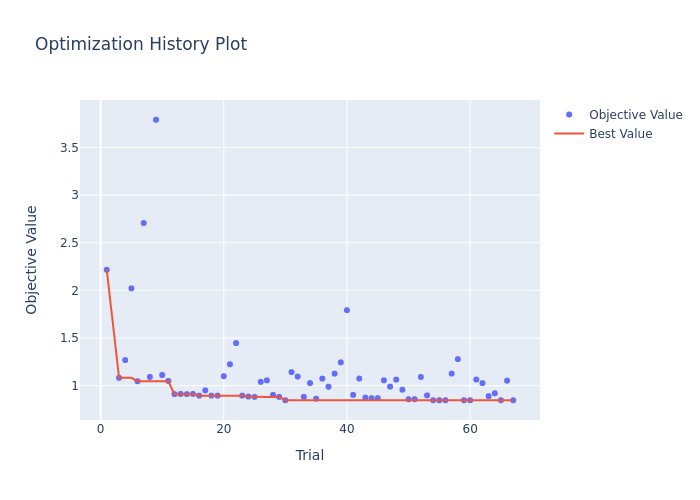

In [11]:
plot_optimization_history(study)

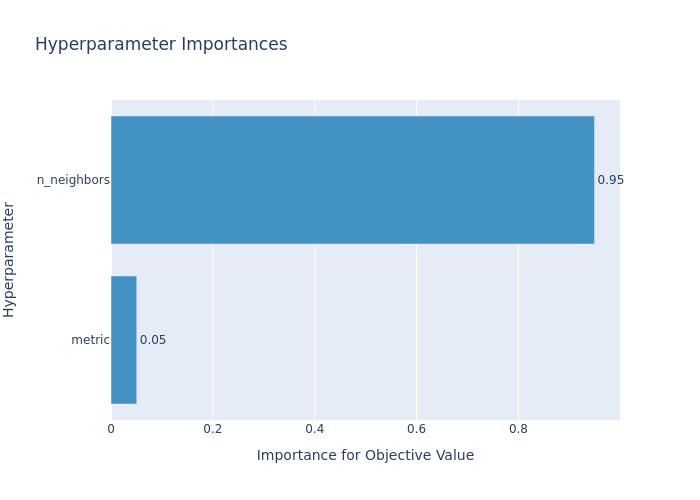

In [12]:
plot_param_importances(study)

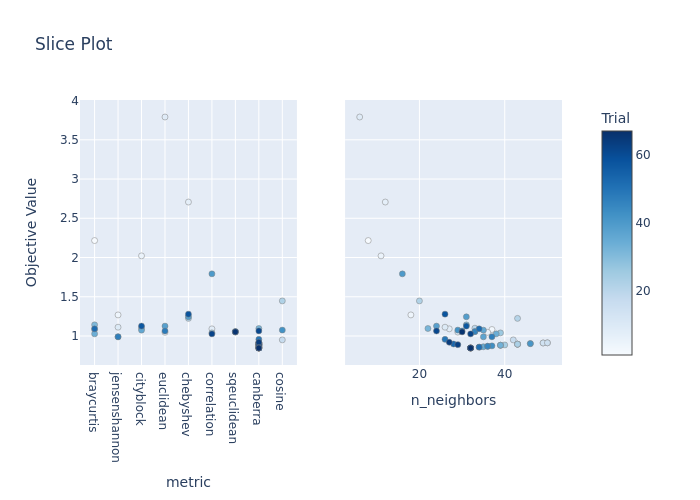

In [13]:
plot_slice(study)

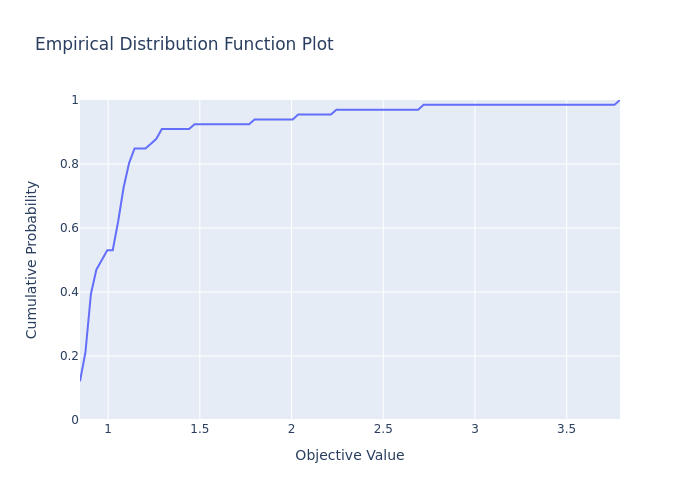

In [14]:
plot_edf(study)

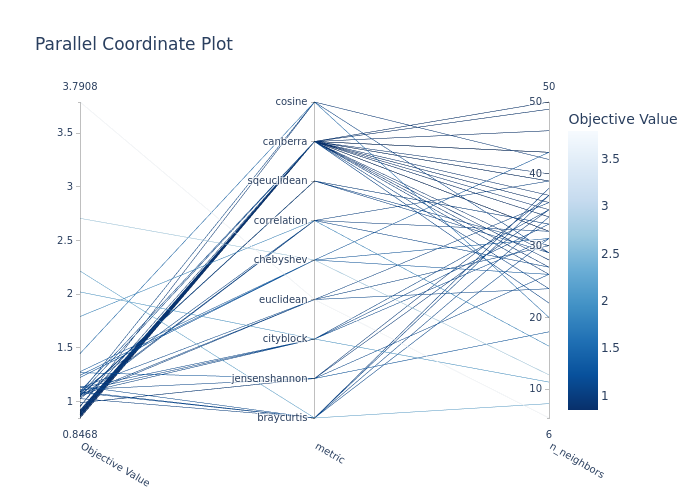

In [15]:
plot_parallel_coordinate(study)

<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [16]:
best_params = dict(study.best_params)
best_params["tol"] = 10**best_params.pop("tol_exp")
best_params

KeyError: 'tol_exp'

***